In [ ]:
This project analyses pedestrian shortest paths from major transport hubs: King’s Cross, St Pancras, Euston, Angel, Holborn, Camden Town, and Tottenham Court Road to the British Library.

The research question is: Which streets capture the highest aggregated footfall, and where would a retail outlet benefit most from this concentration of pedestrians? 

By overlaying shortest walking paths from each station to a common destination, we can identify street segments most heavily travelled, highlighting potential prime retail locations.


In [2]:
#formative assessment

#Neighbourhood Kings Cross Station

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import osmnx as ox
import contextily as ctx

In [14]:

G_street = ox.graph_from_address("King's Cross, London, UK", 
                                  dist=2000, 
                                  network_type= 'walk')  

print(f"Street Network:")
print(f"  Nodes (intersections): {G_street.number_of_nodes()}")
print(f"  Edges (street segments): {G_street.number_of_edges()}")

Street Network:
  Nodes (intersections): 13323
  Edges (street segments): 34676


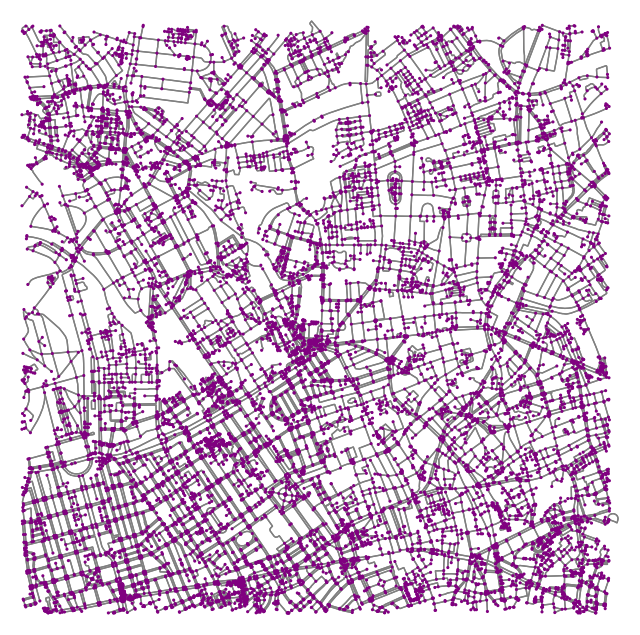

In [17]:
fig, ax = ox.plot_graph(G_street, 
                        figsize=(8, 8),
                        node_size=5,
                        node_color='purple',
                        edge_color='gray',
                        bgcolor='white',
                        show=False,
                        close=False)

plt.axis('off')
plt.show()


Geometry types in King's Cross area: ['Point' 'Polygon' 'MultiPolygon' 'LineString']


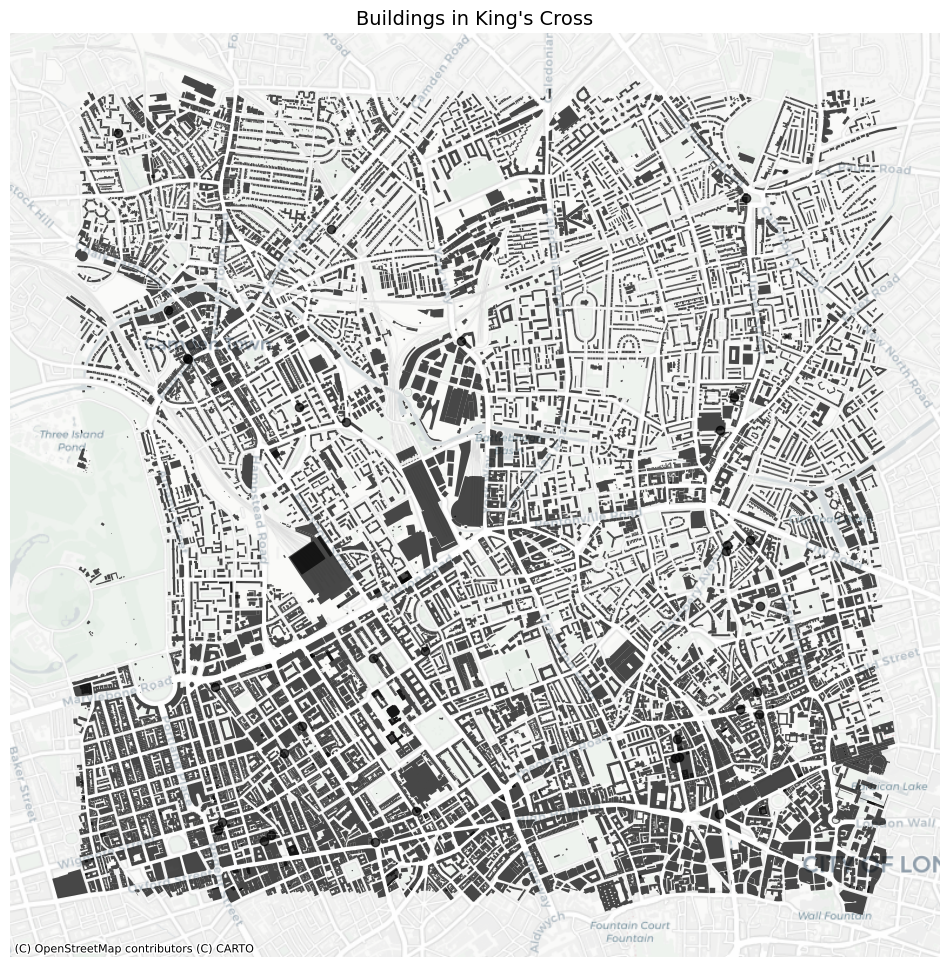

In [33]:
# Building areas King's Cross Station
tags = {'amenity': True, 'highway': True, 'landuse': True, 
        'building': True, 'public_transport': True, 'railway': True}

all_geom_kings = ox.features_from_address("King's Cross, London, UK", tags, dist=2000)
all_geom_kings = all_geom_kings.to_crs(epsg=3857)

print(f"Geometry types in King's Cross area: {all_geom_kings.geometry.type.unique()}")

# Filter for polygons only (buildings are polygons)
geom_kings = all_geom_kings[
    (all_geom_kings.geometry.type == 'Polygon') |
    (all_geom_kings.geometry.type == 'MultiPolygon')
]

# Drop duplicates
geom_kings = geom_kings.drop_duplicates(subset='geometry')

# Plot all buildings in Kings Cross
fig, ax = plt.subplots(figsize=(12, 12))

all_geom_kings[all_geom_kings['building'].notna()].plot(ax=ax, color='black', alpha=0.7)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("Buildings in King's Cross", fontsize=14)
plt.axis('off')
plt.show()


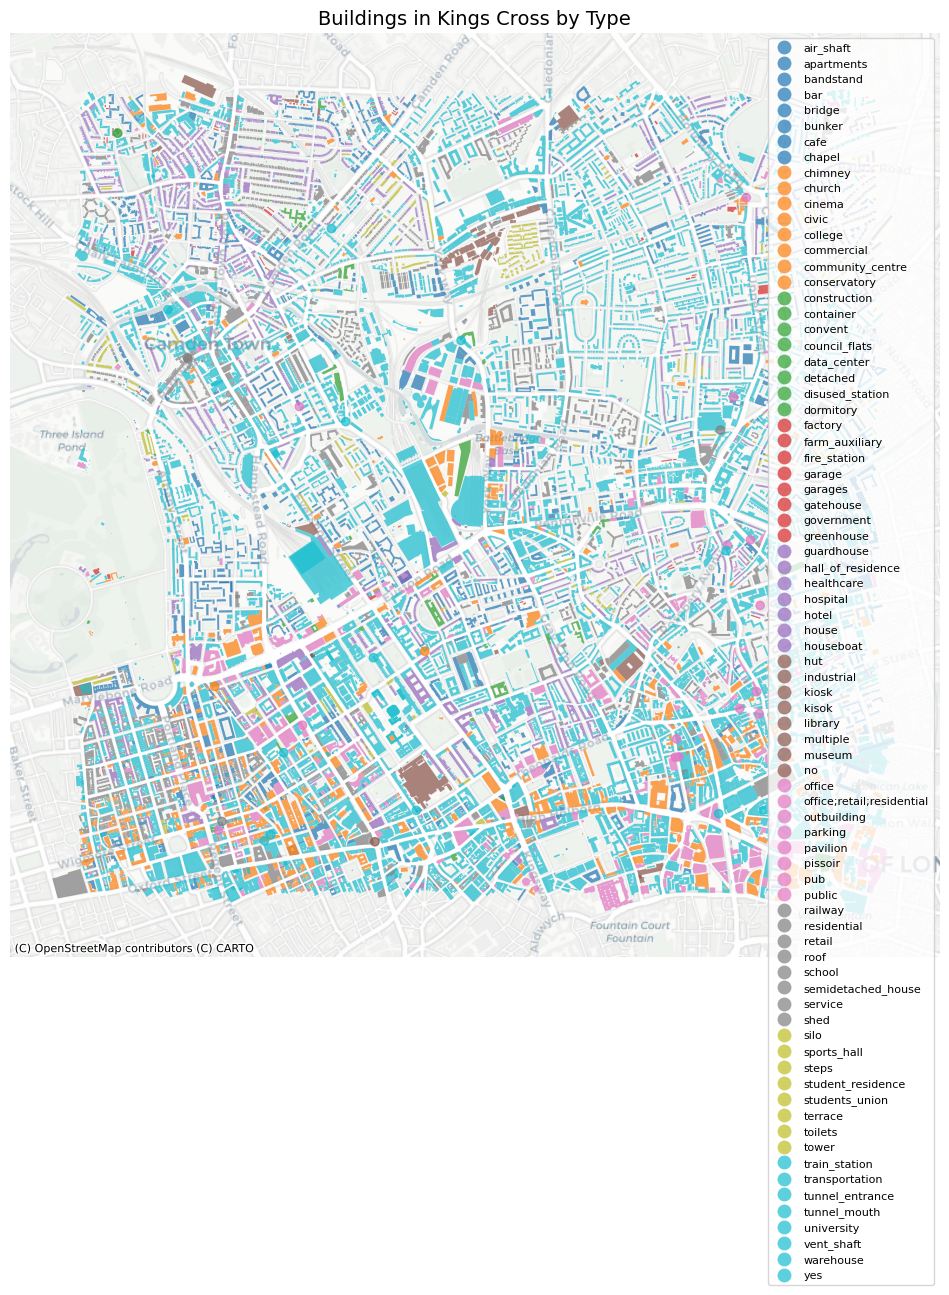

In [35]:
#building types
fig, ax = plt.subplots(figsize=(12, 12))

buildings.plot(column='building',
               ax=ax,
               categorical=True,
               legend=True,
               legend_kwds={'loc': 'upper right', 'fontsize': 8},
               alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("Buildings in Kings Cross by Type", fontsize=14)
plt.axis('off')
plt.show()

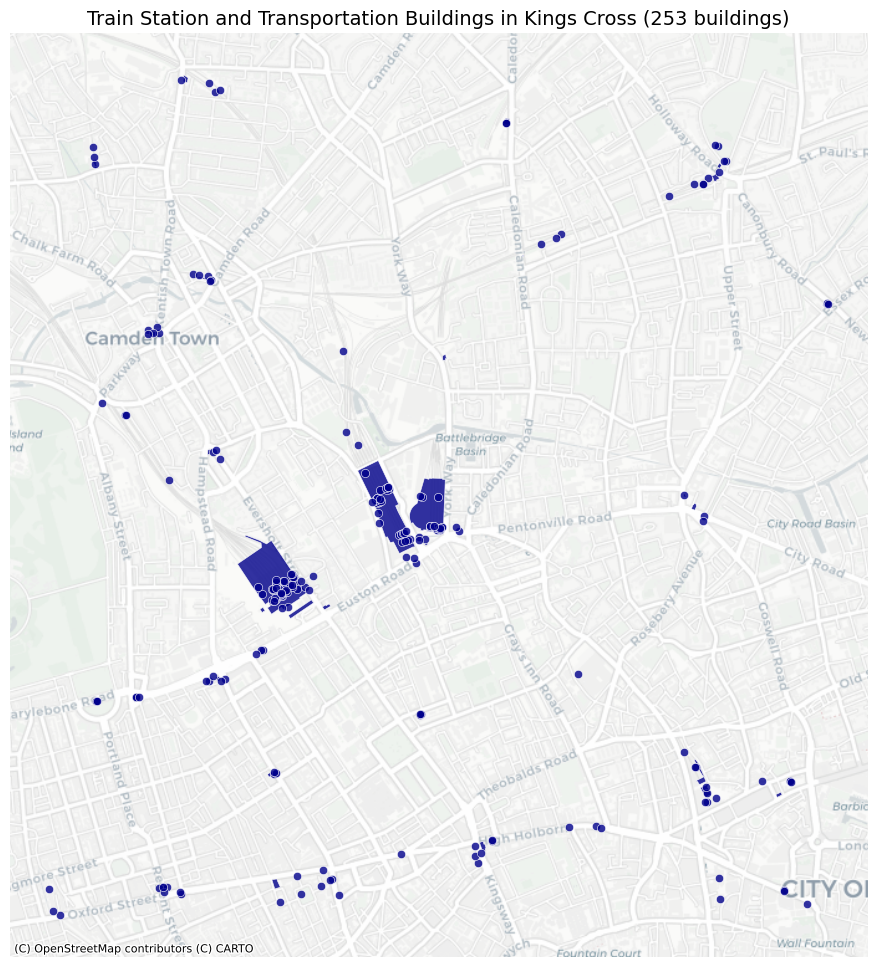

In [37]:
#land use analysis and building types - as transportation
#Filter for train stations and transportation buildings
fig, ax = plt.subplots(figsize=(12, 12))

# Filter
transport_buildings = all_geom_kings[
    (all_geom_kings['building'].notna() & 
     all_geom_kings['building'].str.contains('train|station|transport', case=False, na=False)) |
    (all_geom_kings['amenity'].notna() & 
     all_geom_kings['amenity'].str.contains('train_station|bus_station|transportation', case=False, na=False)) |
    (all_geom_kings['railway'].notna() & 
     all_geom_kings['railway'].str.contains('station|stop', case=False, na=False))
]

# Plot the filtered buildings
transport_buildings.plot(ax=ax, color='darkblue', alpha=0.8, edgecolor='white', linewidth=0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Add title and configure display
plt.title(f"Train Station and Transportation Buildings in Kings Cross ({len(transport_buildings)} buildings)", fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
The street network within a 2 km radius of King’s Cross was obtained from OpenStreetMap using the OSMnx library. Key nodes correspond to major train and underground stations. The analysis focuses on corridors including Euston Road, High Holborn, and Camden Town, connecting King’s Cross with central destinations.

Number of overlapping edges: 0


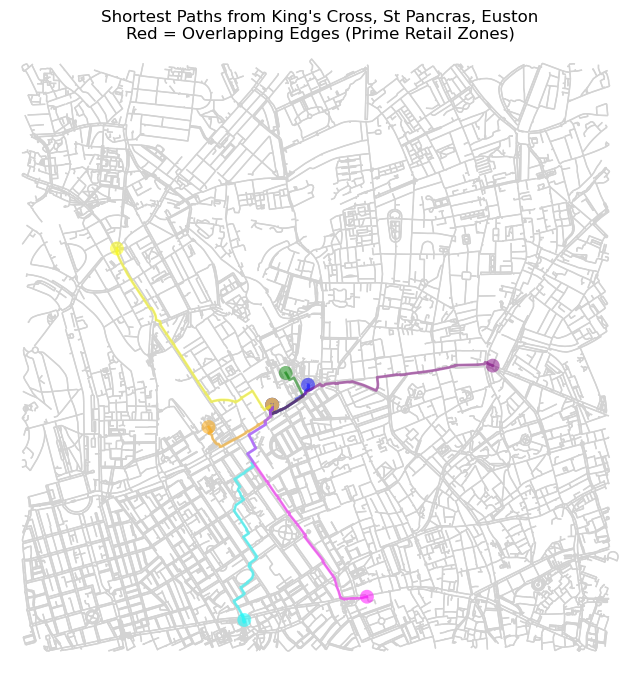

In [42]:
#major stations around King's Cross
Stations = {
    "King's Cross": (51.5308, -0.1238),
    "St Pancras": (51.5316, -0.1260),
    "Euston": (51.5281, -0.1337),
    "Angel": (51.5321, -0.1053),
    "Tottenham Court Road": (51.5163, -0.1300),
    "Holborn": (51.5176, -0.1180),
    "Camden Town": (51.5390, -0.1426)
}

destination = (51.5300, -0.1277) #British Libary 

G = ox.graph_from_address("King's Cross, London, UK", dist=2000, network_type='walk')

# Get nodes for origins and destination
origin_nodes = {name: ox.nearest_nodes(G, lon, lat) for name, (lat, lon) in Stations.items()}
dest_node = ox.nearest_nodes(G, destination[1], destination[0])

# Compute shortest paths
paths = {}
for name, node in origin_nodes.items():
    paths[name] = nx.shortest_path(G, node, dest_node, weight='length')

# Convert paths to sets of edges (tuples of nodes)
path_edges = {name: set(zip(path[:-1], path[1:])) for name, path in paths.items()}

# Find overlapping edges
from functools import reduce
overlap_edges = reduce(lambda x, y: x & y, path_edges.values())

print(f"Number of overlapping edges: {len(overlap_edges)}")

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_color='lightgray', bgcolor='white')

# Plot individual paths
# Define colors for all stations in the Stations dictionary
colors = {
    "King's Cross": 'blue', 
    "St Pancras": 'green', 
    "Euston": 'orange',
    "Angel": 'purple',
    "Tottenham Court Road": 'cyan',
    "Holborn": 'magenta',
    "Camden Town": 'yellow'
}

for name, path in paths.items():
    ox.plot_graph_route(G, path, route_color=colors[name], route_linewidth=2, ax=ax, show=False, close=False)

# Plot overlapping edges bold
for u, v in overlap_edges:
    x, y = zip(*[(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])])
    ax.plot(x, y, color='red', linewidth=5, alpha=0.7, solid_capstyle='round')

ax.set_title("Shortest Paths from King's Cross, St Pancras, Euston\nRed = Overlapping Edges (Prime Retail Zones)")
plt.show()


In [ ]:
Shortest paths were computed from each station to the British Library, with sequences of nodes converted into edges. Routes from each station were plotted in distinct colours, and overlapping edges were highlighted in red to indicate streets used by multiple origins. Only certain streets, primarily along Euston Road, show significant aggregation.

In [ ]:
The analysis indicates that Euston Road experiences the highest convergence of pedestrian paths, suggesting naturally high footfall from multiple stations. Retail outlets along these overlapping streets would capture traffic from library visitors and tourists. While the area is heavily built-up with historical buildings and hotels, some vacant office spaces could be repurposed for retail.
This identifies prime retail zones not just by proximity to individual stations but by aggregated accessibility, combining network centrality and pedestrian flow. These insights can guide location decisions for cafes, convenience stores, or cultural shops seeking maximum visibility along key corridors connecting King’s Cross to the British Library.
